Design a recursion to produce plot in Figure 6. Hint: using a recursive function, produce
vectors px, py with respectively x and y coordinates of endpoints of
your polygons, separating polygons by NaN values

# Recursive Way

In [42]:
using BenchmarkTools

function sierpinski(x,y,size)
    if size == 1
        return ([x,x+1,x,NaN], [y,y,y+1,NaN])
    end

    top_x, top_y = sierpinski(x,y+(2^size), size-1)
    right_x, right_y = sierpinski(x+(2^size),y, size-1)
    base_x, base_y = sierpinski(x,y, size-1)

    return ([base_x;top_x;right_x], 
            [base_y;top_y; right_y])
end


px, py = @btime sierpinski(0,0,11)
# using Plots;
# gr();
# plot(px,py,seriestype=:shape,size=(500,500),
# linewidth=1,grid=false,axis=false,label=false)

  5.274 ms (356478 allocations: 50.82 MiB)


([0.0, 1.0, 0.0, NaN, 0.0, 1.0, 0.0, NaN, 4.0, 5.0  …  4088.0, NaN, 4088.0, 4089.0, 4088.0, NaN, 4092.0, 4093.0, 4092.0, NaN], [0.0, 0.0, 1.0, NaN, 4.0, 4.0, 5.0, NaN, 0.0, 0.0  …  1.0, NaN, 4.0, 4.0, 5.0, NaN, 0.0, 0.0, 1.0, NaN])

# Shift Based

In [43]:
function sierpinski_shift(x,y,size)
    if size == 1
        return ([0,1,0,NaN] .+ x, [0,0,1,NaN] .+ y)
    end

    base_x, base_y = sierpinski_shift(x,y, size-1)
    top_y = base_y .+ 2^size
    right_x = base_x .+ 2^size

    return ([base_x;base_x;right_x], 
            [base_y;top_y;base_y])
end


px, py = @btime sierpinski_shift(0,0,11)
# using Plots;
# gr();
# plot(px,py,seriestype=:shape,size=(500,500),
# linewidth=1,grid=false,axis=false,label=false)

  175.250 μs (114 allocations: 7.21 MiB)


([0.0, 1.0, 0.0, NaN, 0.0, 1.0, 0.0, NaN, 4.0, 5.0  …  4088.0, NaN, 4088.0, 4089.0, 4088.0, NaN, 4092.0, 4093.0, 4092.0, NaN], [0.0, 0.0, 1.0, NaN, 4.0, 4.0, 5.0, NaN, 0.0, 0.0  …  1.0, NaN, 4.0, 4.0, 5.0, NaN, 0.0, 0.0, 1.0, NaN])

## Comments
25x improvements wrt to the previous implementation

# Shift + Memo

In [44]:
using BenchmarkTools

cache = [
    ([0,1,0,NaN], [0,0,1,NaN])
]
function sierpinski_sm(x,y,size)
    base_x = []
    base_y = []
    if size-1 <= length(cache)
        px, py = cache[size-1]
        base_x = px .+ x
        base_y = py .+ y
    else
        base_x, base_y = sierpinski_sm(0,0, size-1)
        push!(cache, (base_x, base_y))
        base_x = base_x .+ x
        base_y = base_y .+ y
    end

    return ([base_x;base_x;base_x .+ 2^(size-2)], 
            [base_y;base_y .+ 2^(size-2);base_y])
end

px, py = @btime sierpinski_sm(0,0,11)

# using Plots;
# gr();
# plot(px,py,seriestype=:shape,size=(500,500),
# linewidth=1,grid=false,axis=false,label=false)

  136.958 μs (28 allocations: 6.01 MiB)


([0.0, 1.0, 0.0, NaN, 0.0, 1.0, 0.0, NaN, 1.0, 2.0  …  1022.0, NaN, 1022.0, 1023.0, 1022.0, NaN, 1023.0, 1024.0, 1023.0, NaN], [0.0, 0.0, 1.0, NaN, 1.0, 1.0, 2.0, NaN, 0.0, 0.0  …  1.0, NaN, 1.0, 1.0, 2.0, NaN, 0.0, 0.0, 1.0, NaN])

# Just For Loops

In [45]:
function sierpinski_loop(size)
    px = [0,1,0, NaN]
    py = [0,0,1, NaN]


    for i in 1:size
        len = length(px)
        px = [px;px;px]
        py = [py;py;py]
        
        px[2*len:end] .+= 2^(i-1)
        py[len:2*len] .+= 2^(i-1)
    end

    return (px, py)
end

px, py = @btime sierpinski_loop(7)

# using Plots;
# gr();
# plot(px,py,seriestype=:shape,size=(500,500),
# linewidth=1,grid=false,axis=false,label=false)


  22.542 μs (74 allocations: 276.19 KiB)


([0.0, 1.0, 0.0, NaN, 0.0, 1.0, 0.0, NaN, 1.0, 2.0  …  126.0, NaN, 126.0, 127.0, 126.0, NaN, 127.0, 128.0, 127.0, NaN], [0.0, 0.0, 1.0, NaN, 1.0, 1.0, 2.0, NaN, 0.0, 0.0  …  1.0, NaN, 1.0, 1.0, 2.0, NaN, 0.0, 0.0, 1.0, NaN])

# For Loops Optimized
Since the final length of the vector in known, we can just preallocate the memory and just update the values in the loop. This give a x1000 performance boost with respect to the first implementation

  8.792 μs (78 allocations: 276.38 KiB)


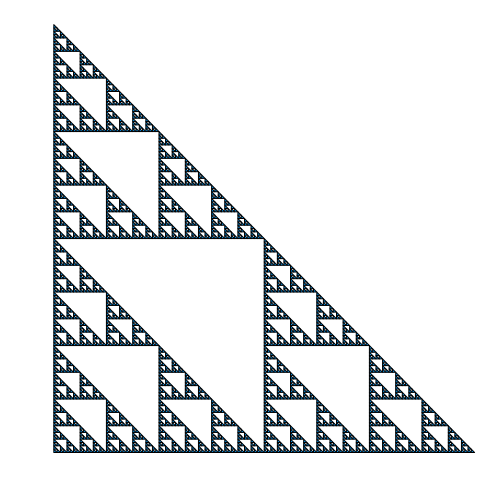

In [ ]:
using BenchmarkTools, Plots

function sierpinski_loop_optimized(size)
    final_length = 4 * 3^size  
    px = zeros(final_length)  
    py = zeros(final_length)  

    # Base triangle 
    px[1:4] .= [0, 1, 0, NaN]
    py[1:4] .= [0, 0, 1, NaN]

    curr = 4  

    for i in 1:size
        # Top Block
        px[curr+1 : 2*curr] .= px[1:curr]
        py[curr+1 : 2*curr] .= py[1:curr] .+ 2^(i-1)
        
        # Right Block
        px[2*curr+1 : curr * 3] .= px[1:curr] .+ 2^(i-1)
        py[2*curr+1 : curr * 3] .= py[1:curr]
        
        curr = new_length
    end

    return px, py
end

px, py = @btime sierpinski_loop_optimized(7);

plot(px, py, seriestype=:shape, size=(500, 500), linewidth=1, grid=false, axis=false, label=false)


# Micro Optimizations

  4.292 μs (10 allocations: 137.06 KiB)


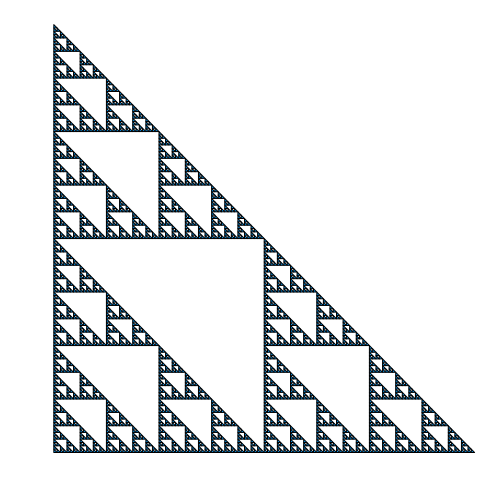

In [49]:
using BenchmarkTools, Plots

function sierpinski_loop_micro_optimized(size)
    final_length = 4 * 3^size  
    px = zeros(final_length)  
    py = zeros(final_length)  

    # Base triangle 
    px[1:4] .= [0, 1, 0, NaN]
    py[1:4] .= [0, 0, 1, NaN]

    curr = 4  

    for i in 1:size
        new_length = curr * 3
        offset = float(1 << (i-1))  # Computes efficiently powers of 2 

        @inbounds begin
            # Creates views
            px_s = @view px[1:curr]
            py_s = @view py[1:curr]


            # Top Block
            px[curr+1 : 2*curr] .= px_s 
            py[curr+1 : 2*curr] .= py_s .+ offset 
            

            # Right Block
            px[2*curr+1 : new_length] .= px_s .+ offset 
            py[2*curr+1 : new_length] .= py_s
        end

        curr = new_length
    end

    return px, py
end

px, py = @btime sierpinski_loop_micro_optimized(7);

plot(px, py, seriestype=:shape, size=(500, 500), linewidth=1, grid=false, axis=false, label=false)
